# <div style="text-align: center; color: #1a5276;">Graph Convolutional Networks</div>


## <font color='blue'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)  
3. [Data](#3) <br>
    3.1. [Exploration](#3.1) <br>
    3.2. [Pre-processing](#3.2) <br>
4. [Model](#4)
5. [Training](#5)
6. [Annex](#6) <br>
    A. [Adjacency matrix](#3.1) <br>
    B. [Feature](#3.2) <br>
7. [References](#references)

<a name="1"></a>
## <font color='blue'> 1. Introduction </font>

This notebook explores how to build custom models in TensorFlow. Additionally, we delve into Graph Convolutional Networks (GCNs) and their applications.

To put theory into practice, we implement a GCN model for the Karate Club dataset, a classic benchmark for graph-based learning. This will help reinforce key concepts such as:

- Building models beyond Keras' predefined layers
- Writing custom training loops for greater flexibility
- Understanding and implementing Graph Convolutional Networks

<a name="2"></a>
## <font color='blue'> 2. Setup </font>

In [1]:
#!pip install spektral

In [49]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import networkx as nx
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input

from spektral.data import Dataset, Graph
from spektral.layers import GCNConv
from sklearn.preprocessing import StandardScaler

In [4]:
SEED = 42

# Set seeds for reproducibility
tf.random.set_seed(SEED)
np.random.seed(SEED)

<a name="3"></a>
## <font color='blue'> 3.  Data </font>

We will use The Karate Club dataset, which is a well-known social network dataset that represents friendships in a karate club. It consists of 34 nodes (members of the club) and 78 edges (friendships).


In [5]:
# Load the Karate Club dataset (networkx)
G = nx.karate_club_graph()

<a name="3.1"></a>
### <font color='#1f618d'> 3.1.  Exploration </font>

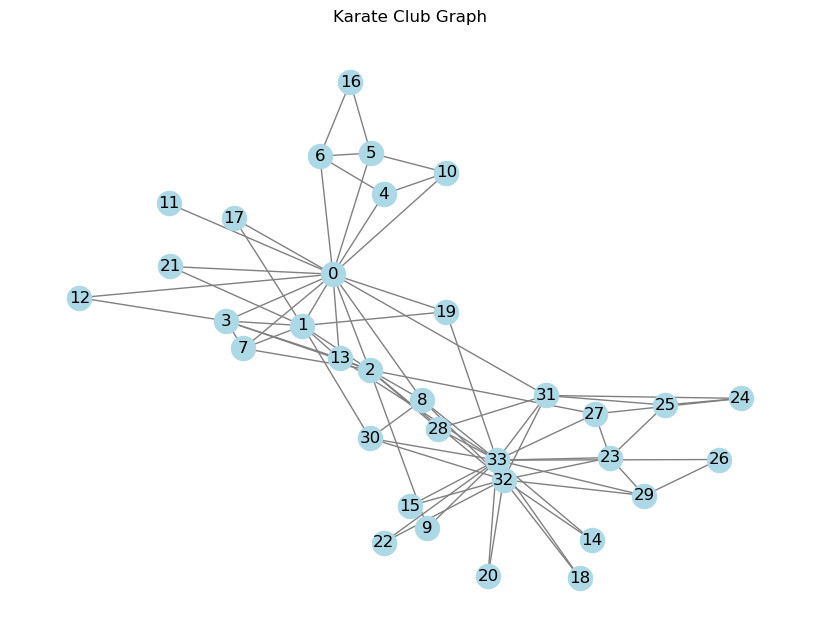

In [6]:
# Let's plot the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray")
plt.title("Karate Club Graph")
plt.show()

In [7]:
# Number of nodes and edges
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 34, Edges: 78


In [8]:
# Check node attributes
print(G.nodes(data=True))

[(0, {'club': 'Mr. Hi'}), (1, {'club': 'Mr. Hi'}), (2, {'club': 'Mr. Hi'}), (3, {'club': 'Mr. Hi'}), (4, {'club': 'Mr. Hi'}), (5, {'club': 'Mr. Hi'}), (6, {'club': 'Mr. Hi'}), (7, {'club': 'Mr. Hi'}), (8, {'club': 'Mr. Hi'}), (9, {'club': 'Officer'}), (10, {'club': 'Mr. Hi'}), (11, {'club': 'Mr. Hi'}), (12, {'club': 'Mr. Hi'}), (13, {'club': 'Mr. Hi'}), (14, {'club': 'Officer'}), (15, {'club': 'Officer'}), (16, {'club': 'Mr. Hi'}), (17, {'club': 'Mr. Hi'}), (18, {'club': 'Officer'}), (19, {'club': 'Mr. Hi'}), (20, {'club': 'Officer'}), (21, {'club': 'Mr. Hi'}), (22, {'club': 'Officer'}), (23, {'club': 'Officer'}), (24, {'club': 'Officer'}), (25, {'club': 'Officer'}), (26, {'club': 'Officer'}), (27, {'club': 'Officer'}), (28, {'club': 'Officer'}), (29, {'club': 'Officer'}), (30, {'club': 'Officer'}), (31, {'club': 'Officer'}), (32, {'club': 'Officer'}), (33, {'club': 'Officer'})]


We can see that we have nodes (representing people), and each node has a label associated, which is either 'Mr. Hi' or 'Officer.' This label indicates which club each person belongs to.

In [9]:
# Check edge list
print(list(G.edges)[:20])  # Show first 20 edges

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13)]


The edge (0, 1) means that node 0 is connected to node 1, and similarly for the other pairs. So, node 0 is connected to nodes 1, 2, 3, 4, and so on, as listed.

In [10]:
# Check the club membership of each node
club_labels = nx.get_node_attributes(G, "club")
print(club_labels)

{0: 'Mr. Hi', 1: 'Mr. Hi', 2: 'Mr. Hi', 3: 'Mr. Hi', 4: 'Mr. Hi', 5: 'Mr. Hi', 6: 'Mr. Hi', 7: 'Mr. Hi', 8: 'Mr. Hi', 9: 'Officer', 10: 'Mr. Hi', 11: 'Mr. Hi', 12: 'Mr. Hi', 13: 'Mr. Hi', 14: 'Officer', 15: 'Officer', 16: 'Mr. Hi', 17: 'Mr. Hi', 18: 'Officer', 19: 'Mr. Hi', 20: 'Officer', 21: 'Mr. Hi', 22: 'Officer', 23: 'Officer', 24: 'Officer', 25: 'Officer', 26: 'Officer', 27: 'Officer', 28: 'Officer', 29: 'Officer', 30: 'Officer', 31: 'Officer', 32: 'Officer', 33: 'Officer'}


In [11]:
# Print first 5 nodes and their connections
for node in list(G.nodes)[:5]:
    print(f"Node {node} (Club: {G.nodes[node]['club']}) is connected to: {list(G.neighbors(node))}")

Node 0 (Club: Mr. Hi) is connected to: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]
Node 1 (Club: Mr. Hi) is connected to: [0, 2, 3, 7, 13, 17, 19, 21, 30]
Node 2 (Club: Mr. Hi) is connected to: [0, 1, 3, 7, 8, 9, 13, 27, 28, 32]
Node 3 (Club: Mr. Hi) is connected to: [0, 1, 2, 7, 12, 13]
Node 4 (Club: Mr. Hi) is connected to: [0, 6, 10]


In [12]:
club_name = "Mr. Hi"  # Change to "Officer" to filter the other club

# Get nodes that belong to the selected club
club_members = [node for node in G.nodes if G.nodes[node]["club"] == club_name]

# Print a few members with their connections
for node in club_members[:5]:  # Show only the first 5 members
    print(f"Node {node} (Club: {G.nodes[node]['club']}) is connected to: {list(G.neighbors(node))}")

Node 0 (Club: Mr. Hi) is connected to: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]
Node 1 (Club: Mr. Hi) is connected to: [0, 2, 3, 7, 13, 17, 19, 21, 30]
Node 2 (Club: Mr. Hi) is connected to: [0, 1, 3, 7, 8, 9, 13, 27, 28, 32]
Node 3 (Club: Mr. Hi) is connected to: [0, 1, 2, 7, 12, 13]
Node 4 (Club: Mr. Hi) is connected to: [0, 6, 10]


To find the most connected members (nodes with the highest degree) in each club, we can:

- Filter nodes by club
- Sort them by degree (number of connections)
- Display the top members for each club

In [13]:
# Find top members for each club
for club_name in ["Mr. Hi", "Officer"]:
    # Get nodes from the selected club
    club_members = [node for node in G.nodes if G.nodes[node]["club"] == club_name]
    
    # Sort members by degree (most connections first)
    sorted_members = sorted(club_members, key=lambda n: G.degree(n), reverse=True)
    
    # Print top 3 most connected members in this club
    print(f"\nTop 3 most connected members in '{club_name}' club:")
    for node in sorted_members[:3]:
        print(f"Node {node} - Degree: {G.degree(node)} - Connections: {list(G.neighbors(node))}")


Top 3 most connected members in 'Mr. Hi' club:
Node 0 - Degree: 16 - Connections: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]
Node 2 - Degree: 10 - Connections: [0, 1, 3, 7, 8, 9, 13, 27, 28, 32]
Node 1 - Degree: 9 - Connections: [0, 2, 3, 7, 13, 17, 19, 21, 30]

Top 3 most connected members in 'Officer' club:
Node 33 - Degree: 17 - Connections: [8, 9, 13, 14, 15, 18, 19, 20, 23, 26, 27, 28, 29, 30, 31, 32, 22]
Node 32 - Degree: 12 - Connections: [2, 8, 14, 15, 18, 20, 22, 23, 29, 30, 31, 33]
Node 31 - Degree: 6 - Connections: [0, 24, 25, 28, 32, 33]


The **degree** of a node in a graph represents the number of edges connected to it. The degree distribution shows how these degrees are spread across all nodes in the network.


If a degree appears often in the histogram, many members have that number of friendships.
In general, a few nodes might have high degrees, representing influential members (like the club leaders).
Most nodes have low degrees, meaning they are only connected to a few members.
This helps analyze the network structure, identifying hubs (high-degree nodes) and isolated individuals (low-degree nodes).


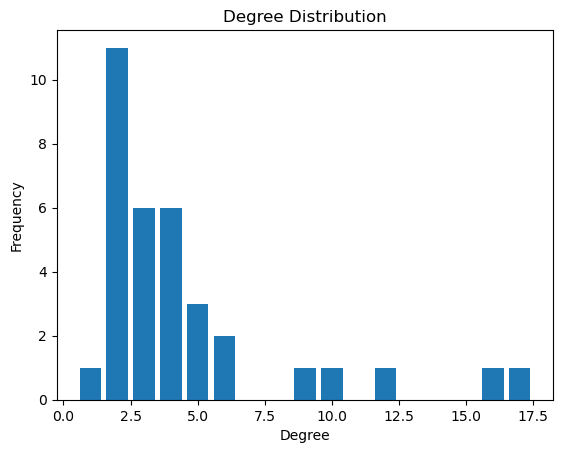

In [14]:
# This extracts the degree of each node in the graph.
# G.degree(n) returns the number of edges connected to node n.
# The result is a list of degrees for all nodes.
degrees = [G.degree(n) for n in G.nodes()]

# histogram
plt.hist(degrees, bins=range(1, max(degrees)+2), align='left', rwidth=0.8)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()

Finally, let's plot the graph with colors differentiating which class each node belongs to:

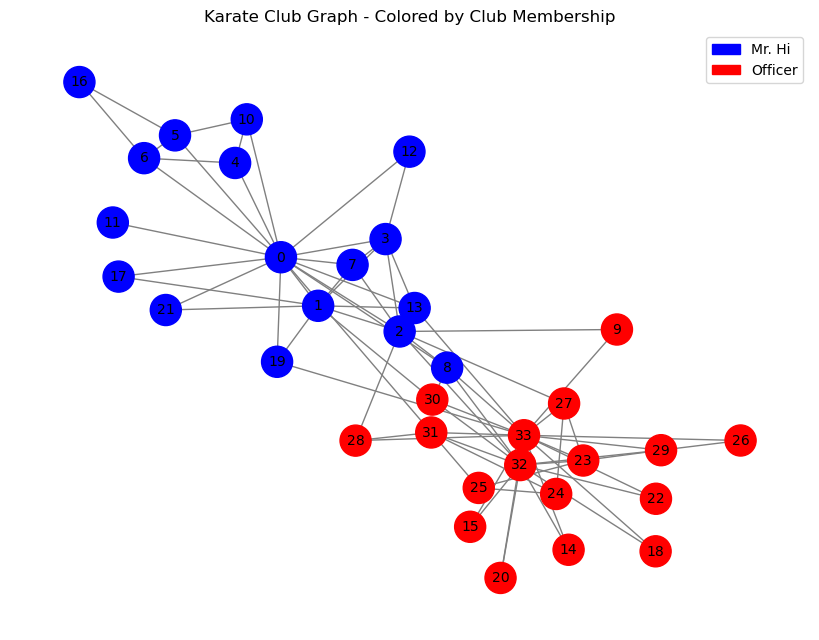

In [15]:
# Assign colors based on club membership
club_colors = {"Mr. Hi": "blue", "Officer": "red"}
node_colors = [club_colors[G.nodes[n]["club"]] for n in G.nodes]

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=node_colors, edge_color="gray", node_size=500, font_size=10)

# Add a legend
from matplotlib.patches import Patch
legend_handles = [Patch(color=color, label=club) for club, color in club_colors.items()]
plt.legend(handles=legend_handles, loc="upper right")

plt.title("Karate Club Graph - Colored by Club Membership")
plt.show()

<a name="3.2"></a>
### <font color='#1f618d'> 3.2. Pre-processing</font>

In [16]:
# number of nodes
num_nodes = len(G)
num_nodes

34

In [17]:
# Compute adjacency matrix and normalize it
#adj = nx.adjacency_matrix(G).astype(np.float32)
adj = (nx.adjacency_matrix(G) > 0).astype(np.float32)
adj += sp.eye(adj.shape[0])  # Add self-loops
degree_matrix = np.array(adj.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))
adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt
adj = tf.convert_to_tensor(adj_normalized, dtype=tf.float32)

In [18]:
adj.shape

TensorShape([34, 34])

### Features

In [19]:
# Compute node features
one_hot_features = np.eye(num_nodes, dtype=np.float32)
degrees = np.array([G.degree(n) for n in G.nodes()], dtype=np.float32).reshape(-1, 1)
clustering_coeffs = np.array([nx.clustering(G, n) for n in G.nodes()], dtype=np.float32).reshape(-1, 1)
betweenness = np.array(list(nx.betweenness_centrality(G).values()), dtype=np.float32).reshape(-1, 1)
pagerank = np.array(list(nx.pagerank(G).values()), dtype=np.float32).reshape(-1, 1)

In [20]:
# Standardize numerical features
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
numeric_features = scaler.fit_transform(np.hstack([degrees, clustering_coeffs, betweenness, pagerank]))

In [21]:
# Access mean and standard deviation
print("Feature Means:", scaler.mean_)  # Mean of each column before scaling
print("Feature Standard Deviations:", scaler.scale_)  # Standard deviation of each column before scaling

Feature Means: [4.58823529 0.57063848 0.04400624 0.02941176]
Feature Standard Deviations: [3.82036068 0.34226601 0.09254295 0.02236985]


In [22]:
# Concatenate all features
features = np.hstack([one_hot_features, numeric_features])
features = tf.convert_to_tensor(features, dtype=tf.float32)

In [23]:
features.shape

TensorShape([34, 38])

In [24]:
features[0].shape

TensorShape([38])

In [25]:
features[0] # one hot for nodes, and then other 4 features (degrees, clustering_coeffs, betweenness, pagerank)

<tf.Tensor: shape=(38,), dtype=float32, numpy=
array([ 1.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  2.987091 ,
       -1.2289811,  4.253474 ,  2.6417842], dtype=float32)>

### Labels

In [26]:
# Convert labels (0 for 'Mr. Hi' club, 1 for 'Officer' club)
labels = np.array([G.nodes[i]['club'] != 'Mr. Hi' for i in range(num_nodes)], dtype=np.int32)

In [27]:
labels.shape

(34,)

In [28]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

### Train/Test Split

In [29]:
# Train/test split
train_mask = np.zeros(num_nodes, dtype=bool)
train_mask[:17] = True  # First 17 nodes for training; arbitrary value
test_mask = ~train_mask
train_mask = tf.convert_to_tensor(train_mask)
test_mask = tf.convert_to_tensor(test_mask)

In [30]:
train_mask # first 17s are true and the other false

<tf.Tensor: shape=(34,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])>

In [31]:
test_mask # last 34-17=17 are true, and the other are false

<tf.Tensor: shape=(34,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])>

<a name="4"></a>
## <font color='blue'> 4. Model </font>

We will build the following model:

<img src="images/gcn.png"/>

<br>

This model can be used to predict group memberships of each club member. The goal is to classify nodes into two groups (Mr. Hi or Officer)

First, we will implement the GCN layer:


<img src="images/gcn_layer.png" style="width: 30%;" />

In [32]:
# Define GCN layer
class GCNLayer(Layer):
    """
    A Graph Convolutional Network (GCN) layer.

    This layer performs graph convolution by aggregating information from neighboring nodes 
    using the adjacency matrix. It applies a linear transformation followed by an optional 
    activation function.

    Args:
        units (int): Number of output features.
        activation (str or callable, optional): Activation function to apply. Default is None.
        l2_reg (float, optional): L2 regularization factor for weight decay. Default is 1e-3.
    """

    def __init__(self, units, activation=None, l2_reg=1e-3, **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units  # Number of output features
        self.activation = tf.keras.activations.get(activation)  # Activation function
        self.l2_reg = l2_reg  # L2 regularization factor

    def build(self, input_shape):
        """Initialize the layer's weights."""
        num_features = input_shape[0][-1]  # Get the number of input features

        # Weight matrix for feature transformation
        self.w = self.add_weight(shape=(num_features, self.units),
                                 initializer='glorot_uniform',
                                 regularizer=tf.keras.regularizers.l2(self.l2_reg),
                                 trainable=True)

        # Bias term
        self.b = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)

    def call(self, inputs):
        """
        Forward pass of the GCN layer.

        Args:
            inputs (tuple): A tuple containing:
                - features (tf.Tensor): Node feature matrix of shape (num_nodes, num_features).
                - adj (tf.Tensor): Adjacency matrix of shape (num_nodes, num_nodes).

        Returns:
            tf.Tensor: The transformed node features after applying graph convolution.
        """
        features, adj = inputs  # Unpack inputs: node features and adjacency matrix

        # Apply linear transformation to node features
        support = tf.matmul(features, self.w)

        # Aggregate neighbor information using adjacency matrix
        adj_features = tf.matmul(adj, support)

        # Add bias term
        output = adj_features + self.b

        # Apply activation function (if specified)
        return self.activation(output) if self.activation else output


Now, let's implement the entire model:

In [33]:
# Define GCN Model
class GCNModel(tf.keras.Model):
    """
    A Graph Convolutional Network (GCN) model using two GCN layers.

    This model consists of:
    - Two GCN layers for message passing
    - Batch normalization for stable training
    - Dropout for regularization

    Args:
        hidden_units (int): Number of hidden units in the first GCN layer.
        num_classes (int): Number of output classes (logits).
        dropout_rate (float, optional): Dropout rate for regularization. Default is 0.2.
    """

    def __init__(self, hidden_units, num_classes, dropout_rate=0.2):
        super(GCNModel, self).__init__()
        self.gcn1 = GCNLayer(hidden_units, activation='relu')  # First GCN layer with ReLU activation
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)  # Dropout after first layer
        self.gcn2 = GCNLayer(num_classes)  # Second GCN layer (outputs raw logits)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)  # Dropout after second layer
        self.batch_norm = tf.keras.layers.BatchNormalization()  # Batch normalization for stability

    def call(self, inputs, training=False):
        """
        Forward pass of the GCN model.

        Args:
            inputs (tuple): A tuple containing:
                - features (tf.Tensor): Node feature matrix of shape (num_nodes, num_features).
                - adj (tf.Tensor): Adjacency matrix of shape (num_nodes, num_nodes).
            training (bool, optional): Whether the model is in training mode (for dropout and batch norm). Default is False.

        Returns:
            tf.Tensor: The output logits of shape (num_nodes, num_classes).
        """
        features, adj = inputs  # Unpack inputs: node features and adjacency matrix

        # First GCN layer with batch normalization and dropout
        x = self.gcn1((features, adj))
        x = self.batch_norm(x, training=training)  # Batch norm active only in training mode
        x = self.dropout1(x, training=training)  # Apply dropout if training

        # Second GCN layer followed by dropout
        x = self.gcn2((x, adj))
        x = self.dropout2(x, training=training)  # Apply dropout if training

        return x  # Return logits


In [34]:
# Instantiate model
model = GCNModel(hidden_units=16, num_classes=2, dropout_rate=0.2)

<a name="5"></a>
## <font color='blue'> 5. Training </font>

In [35]:
# loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # the model returns logits

In [36]:
# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

### Custom training loop

In [37]:
# Training loop
epochs = 500
best_accuracy = 0
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        logits = model((features, adj), training=True)
        loss_value = loss_fn(labels[train_mask], logits[train_mask])
    
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Compute test accuracy
    logits = model((features, adj), training=False)
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    correct_predictions = tf.equal(predictions[test_mask], labels[test_mask])
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32)).numpy()

    if accuracy > best_accuracy:
        best_accuracy = accuracy

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, Test Accuracy: {accuracy}")

Epoch 0, Loss: 1.1907602548599243, Test Accuracy: 0.1764705926179886
Epoch 50, Loss: 0.08256039768457413, Test Accuracy: 0.1764705926179886
Epoch 100, Loss: 0.016263887286186218, Test Accuracy: 0.1764705926179886
Epoch 150, Loss: 0.01843993365764618, Test Accuracy: 0.1764705926179886
Epoch 200, Loss: 0.0444871261715889, Test Accuracy: 0.1764705926179886
Epoch 250, Loss: 0.04225930571556091, Test Accuracy: 0.47058823704719543
Epoch 300, Loss: 0.003308933461084962, Test Accuracy: 0.47058823704719543
Epoch 350, Loss: 0.12300582230091095, Test Accuracy: 0.529411792755127
Epoch 400, Loss: 0.08264454454183578, Test Accuracy: 0.7058823704719543
Epoch 450, Loss: 0.04169393703341484, Test Accuracy: 0.7647058963775635


In [38]:
print(f"Final Test Accuracy: {best_accuracy}")

Final Test Accuracy: 0.8235294222831726


<a name="annex"></a>
## <font color='blue'> Annex </font>

<a name="A"></a>
### <font color='#1f618d'> A. Adjacency Matrix </font>

In graph theory and computer science, an adjacency matrix is a square matrix used to represent a finite graph. The elements of the matrix indicate whether pairs of vertices are adjacent or not in the graph.

In the special case of a finite simple graph, the adjacency matrix is a (0,1)-matrix with zeros on its diagonal. If the graph is undirected (i.e. all of its edges are bidirectional), the adjacency matrix is symmetric. 

In [39]:
adj = (nx.adjacency_matrix(G) > 0).astype(np.float32)
adj.toarray()

array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]], dtype=float32)

In this case, the matrix represents connections (1) or no connections (0), but it is worth noting that some adjacency matrices are weighted and can contain values different from 0 and 1.

So, basically, we have:

- Binary adjacency matrix (0/1): 
    - Represents whether nodes are connected (1) or not (0).
- Weighted adjacency matrix: 
    - Can have values other than 0 and 1, representing connection strength, distance, or other relationship metrics

A **self-loop** is an edge that connects a node to itself. In an adjacency matrix, self-loops appear as 1s on the diagonal (i.e., adj[i, i] = 1).

The Karate Club graph (nx.karate_club_graph()) does not include self-loops by default. The adjacency matrix for this dataset initially has only 0s on the diagonal.

Why Add Self-Loops?
In Graph Convolutional Networks (GCNs), self-loops are often added because:

- They allow each node to keep some of its original features in the message-passing process.
- They stabilize learning by preventing nodes from relying only on their neighbors' features.

In [40]:
# sp.eye(adj.shape[0]) creates an identity matrix of the same size as adj, 
# Adding it to adj ensures that every node has a self-loop.
adj += sp.eye(adj.shape[0])  # Add self-loops
adj.toarray()

array([[1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

Note that now we have 1s in the main diagonal.

This following code **normalizes** the adjacency matrix using the Symmetric Normalized Laplacian:
    
$$
\tilde{A} = D^{-\frac{1}{2}} A D^{-\frac{1}{2}}
$$

- A is the adjancey matrix
- D is the degree matrix
- D**(-1/2) is the inverse square root of D.


The degree matrix D is a diagonal matrix where each diagonl entry Dii represents the degree (number of connections) of node i.

In [41]:
degree_matrix = np.array(adj.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))
adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt
adj = tf.convert_to_tensor(adj_normalized, dtype=tf.float32)

adj

<tf.Tensor: shape=(34, 34), dtype=float32, numpy=
array([[0.05882353, 0.0766965 , 0.07312724, ..., 0.09166985, 0.        ,
        0.        ],
       [0.0766965 , 0.1       , 0.09534626, ..., 0.        , 0.        ,
        0.        ],
       [0.07312724, 0.09534626, 0.09090909, ..., 0.        , 0.0836242 ,
        0.        ],
       ...,
       [0.09166985, 0.        , 0.        , ..., 0.14285715, 0.10482848,
        0.08908708],
       [0.        , 0.        , 0.0836242 , ..., 0.10482848, 0.07692308,
        0.06537204],
       [0.        , 0.        , 0.        , ..., 0.08908708, 0.06537204,
        0.05555556]], dtype=float32)>

<a name="B"></a>
### <font color='#1f618d'> B. Features </font>

### One-hot encoding

The following code creates a one-hot encoded feature matrix for num_nodes.

- np.eye(num_nodes, dtype=np.float32) generates an identity matrix of size (num_nodes, num_nodes).

In [42]:
one_hot_features = np.eye(num_nodes, dtype=np.float32)
one_hot_features

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

### Degrees

In [43]:
# This computes the degree of each node in the graph G and stores it as a column vector
degrees = np.array([G.degree(n) for n in G.nodes()], dtype=np.float32).reshape(-1, 1)
degrees.shape, degrees[:5]

((34, 1),
 array([[16.],
        [ 9.],
        [10.],
        [ 6.],
        [ 3.]], dtype=float32))

For instance, we can see that the first node (node 0) has a degree of 16: that means it has 16 edges connecting it to other nodes. 

### Clustering coefficient

The clustering coefficient of a node measures how tightly connected its neighbors are. 

A higher clustering coefficient indicates a more interconnected network,

In [44]:
# This computes the clustering coefficient for each node in the graph G and stores it as a column vector
clustering_coeffs = np.array([nx.clustering(G, n) for n in G.nodes()], dtype=np.float32).reshape(-1, 1)
clustering_coeffs.shape, clustering_coeffs[:5]

((34, 1),
 array([[0.15      ],
        [0.33333334],
        [0.24444444],
        [0.6666667 ],
        [0.6666667 ]], dtype=float32))

Let's analyze the results:

- 0.15 → This node has a low clustering coefficient, meaning its neighbors are weakly connected.
- 0.33 → Moderate clustering; about 33% of possible connections among its neighbors exist.
- 0.24 → Similar to the previous one, showing weak to moderate connectivity.
- 0.67 → High clustering; about 67% of possible connections among its neighbors exist.
- 0.67 → Another highly clustered node with strong local connectivity.

In summary, some nodes (like those with 0.67) belong to well-connected groups, while others (like 0.15) are in less tightly-knit neighborhoods.

### Betweenness centrality 

Measures how often a node appears on the shortest paths between other nodes.

A higher betweenness centrality indicates that the node is a key bridge in the network, while lower values mean the node has little influence in connecting different parts.

In [45]:
# This computes the betweenness centrality for each node in the graph G and stores it as a column vector
betweenness = np.array(list(nx.betweenness_centrality(G).values()), dtype=np.float32).reshape(-1, 1)

betweenness.shape, betweenness[:5]

((34, 1),
 array([[0.43763527],
        [0.05393669],
        [0.1436568 ],
        [0.01190927],
        [0.00063131]], dtype=float32))

Let's analyze the results:

- 0.4376 → This node plays a major role in connecting different parts of the network.
- 0.0539 → Low centrality, meaning it rarely lies on the shortest paths.
- 0.1437 → Moderate importance in network flow.
- 0.0119 → Almost no influence in connecting nodes.
- 0.0006 → Very low centrality, likely peripheral in the network.

### Pagerank

PageRank is an algorithm that measures the importance of nodes in a graph, originally designed for ranking web pages.

A higher PageRank means a node is more influential in the network (e.g., it has many incoming links or is linked by important nodes). A lower PageRank suggests the node has limited connectivity or influence.

In [46]:
# This computes the PageRank score for each node in the graph G and stores it as a column vector
pagerank = np.array(list(nx.pagerank(G).values()), dtype=np.float32).reshape(-1, 1)
pagerank.shape, pagerank[:5]

((34, 1),
 array([[0.08850808],
        [0.05741484],
        [0.06276686],
        [0.03721208],
        [0.02050398]], dtype=float32))

Let's analyze the results:

- 0.0885 → This node has the highest PageRank, meaning it's an important or highly connected node.
- 0.0574 → Moderately important, with some influence.
- 0.0628 → Slightly more important than the previous one.
- 0.0372 → Low importance, likely not well-connected.
- 0.0205 → Very low PageRank, possibly a peripheral node with few connections.


<a name="references"></a>
## <font color='blue'> References </font>


https://journalofbigdata.springeropen.com/articles/10.1186/s40537-023-00876-4

https://networkx.org/documentation/stable/reference/generated/networkx.linalg.graphmatrix.adjacency_matrix.html


https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

https://en.wikipedia.org/wiki/Adjacency_matrix

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering

https://en.wikipedia.org/wiki/Betweenness_centrality

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html

https://en.wikipedia.org/wiki/Clustering_coefficient

